# TAREA: Entrenamiento de un perceptrón multicapa (MLP)

## Realizado por Jesús Martínez Leal y Miguel Muñoz Blat

## Tareas a Resolver

- Define las funciones de activación
- Implementa el algoritmo de aprendizaje (BP)
- Calcula la salida para unos datos de test [0,2pi]
- Representa la salida estimada y la deseada

- Modifica la constante de adaptación
- Modifica el número de neuronas en la capa oculta
- Emplea la función de activación sigmoide en lugar de tanh 
- Predice valores fuera del rango de entrenamiento [0,4pi]

### Manera "manual"

Se completa primeramente lo necesario para el entrenamiento de este perceptrón multicapa, tal y como se indicaba.

In [44]:
import numpy as np
np.random.seed(42) # fijo la semilla de aleatoriedad para todo el código

In [45]:
import numpy as np

# Definimos las funciones de activación y sus derivadas
def sigmoid_fn(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_dfn(x):
    s = sigmoid_fn(x)
    return s * (1 - s)

def tanh_fn(x):
    return np.tanh(x)

def tanh_dfn(x):
    t = tanh_fn(x)
    return 1 - t ** 2

# Elegimos función activación
activation_fn  = tanh_fn
activation_dfn = tanh_dfn

epoch = 0
reportFreq = 100000

learning_rate = 0.01

sample_size = 1  #capa 0 entrada
hidden_size = 15  #capa 1 oculta
output_size = 1   #capa 2 salida 

error       = np.zeros( ( output_size, 1 ) )

# Inicializamos pesos y bias de las dos capas (neuronas en filas, entradas en columnas):
layer1_weights = np.random.rand(hidden_size, sample_size)
layer1_bias = np.random.rand(hidden_size, 1) # cada neurona de la capa con un bias

layer2_weights = np.random.rand(output_size, hidden_size)
layer2_bias = np.random.rand(output_size, 1)

# Épocas de entrenamiento (Algoritmo Backpropagation):
while epoch <= 1e6:
    
    # Generación del conjunto de entrenamiento online (sinusoide)
    # Elegimos una muestra de entrada (uniforme [0-2pi]):
    sample_vec = np.random.uniform(0.0, np.pi * 2.0, (sample_size, 1))
    # Calculamos la salida (seno(x)):
    output_vec = np.sin(sample_vec)

    # Propagamos hacia adelante (entrada a oculta):
    layer1_sums = np.dot(layer1_weights, sample_vec) + layer1_bias
    layer1_outputs = activation_fn(layer1_sums)

    # Propagamos hacia adelante (oculta a salida):
    layer2_sums = np.dot(layer2_weights, layer1_outputs) + layer2_bias
    layer2_outputs = activation_fn(layer2_sums)


    # Retropropagamos errores (salida a oculta):
    layer2_deltas = - (output_vec - layer2_outputs) * activation_dfn(layer2_sums) # hacemos el (deseado - obtenido) y luego lo multiplicamos por la derivada

    # Retropropagamos errores (oculta a entrada):
    layer1_deltas = np.dot(layer2_weights.T, layer2_deltas) * activation_dfn(layer1_sums) # así sale dimensión (hidden, 1)

    # Actualizamos pesos aplicando las deltas (capa 0):
    layer1_weights -= learning_rate * np.dot(layer1_deltas, sample_vec.T) # así sale dimensión (hidden, sample)
    layer1_bias -= learning_rate * layer1_deltas
    
    # Actualizamos pesos aplicando las deltas (capa 1):
    layer2_weights -= learning_rate * np.dot(layer2_deltas, layer1_outputs.T)
    layer2_bias -= learning_rate * layer2_deltas

    # Calculamos error para mostrar:
    error += np.absolute(output_vec - layer2_outputs)
    
    # Mostramos el error:
    if epoch % reportFreq == 0:
        print("Epoch: %d\nError: %f" % (epoch, np.sum(error) / float(sample_size) / float(reportFreq))) # error promedio en el intervalo hasta ciertas iteraciones
        error = np.zeros((sample_size, 1)) # contador en 0 de nuevo para el error...

    # Incrementamos la epoca (iteramos)
    epoch += 1

Epoch: 0
Error: 0.000001
Epoch: 100000
Error: 0.442814
Epoch: 200000
Error: 0.125134
Epoch: 300000
Error: 0.080854
Epoch: 400000
Error: 0.038403
Epoch: 500000
Error: 0.029901
Epoch: 600000
Error: 0.027000
Epoch: 700000
Error: 0.025496
Epoch: 800000
Error: 0.024704
Epoch: 900000
Error: 0.024155
Epoch: 1000000
Error: 0.023589


In [46]:
# Test: aplico la red a nuevos datos
x = np.linspace(0.0, np.pi * 2.0, 20)
d = np.sin( x )

y = np.zeros( ( x.size, 1 ) )
for i, sample_vec in enumerate(x):
    
    # Propagamos hacia adelante (entrada a oculta):
    layer1_sums = np.dot(layer1_weights, sample_vec) + layer1_bias
    layer1_outputs = activation_fn(layer1_sums)

    # Propagamos hacia adelante (oculta a salida):
    layer2_sums = np.dot(layer2_weights, layer1_outputs) + layer2_bias
    layer2_outputs = activation_fn(layer2_sums)

    # Almaceno la salida
    y[i] = layer2_outputs

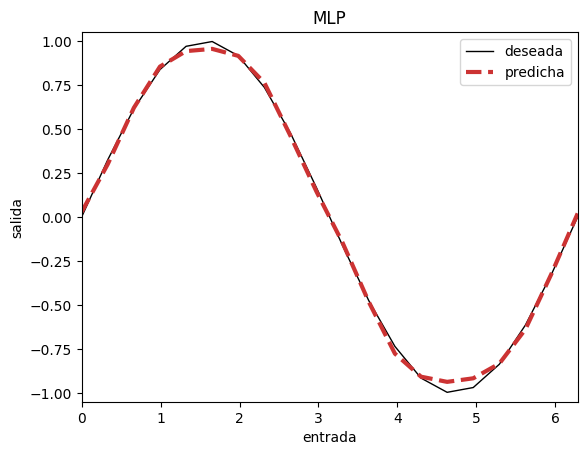

In [47]:
# Representación de la salida estimada
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(x, d, 'k-', label='deseada', lw=1)
plt.plot(x, y, '--', color=(0.8, 0.2, 0.2), label='predicha', lw=3)

plt.xlim([0.0, x.max(0)])
plt.ylim([-1.05, 1.05])
plt.xlabel('entrada')
plt.ylabel('salida')
plt.title('MLP')
plt.legend(loc="upper right")

### Implementación de funciones en esta manera manual

Con el objetivo de que sea más sencilla la manipulación en el entrenamiento del modelo se propone definir una función que incluya los pasos incorporados antes.

In [48]:
# Definimos las funciones de activación y sus derivadas
def sigmoid_fn(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_dfn(x):
    s = sigmoid_fn(x)
    return s * (1 - s)

def tanh_fn(x):
    return np.tanh(x)

def tanh_dfn(x):
    t = tanh_fn(x)
    return 1 - t ** 2

In [49]:
import numpy as np

def train_MLP(sample_size = 1, hidden_size = 10, output_size = 1, learning_rate = 0.05, activation_fn = np.tanh, activation_dfn = None, epochs = 1000000, report_freq = 200000):
    
    # Definición de funciones de activación y sus derivadas
    if activation_fn == np.tanh:
        activation_dfn = lambda x: 1 - np.tanh(x) ** 2
    elif activation_fn == sigmoid_fn:
        activation_dfn = lambda x: sigmoid_fn(x) * (1 - sigmoid_fn(x))

    # Inicialización de pesos y sesgos
    layer1_weights = np.random.rand(hidden_size, sample_size)
    layer1_bias = np.random.rand(hidden_size, 1)
    layer2_weights = np.random.rand(output_size, hidden_size)
    layer2_bias = np.random.rand(output_size, 1)

    epoch = 0
    error = np.zeros((output_size, 1))

    # Entrenamiento del modelo
    while epoch <= epochs:
        sample_vec = np.random.uniform(0.0, np.pi * 2.0, (sample_size, 1))
        output_vec = np.sin(sample_vec)

        layer1_sums = np.dot(layer1_weights, sample_vec) + layer1_bias
        layer1_outputs = activation_fn(layer1_sums)

        layer2_sums = np.dot(layer2_weights, layer1_outputs) + layer2_bias
        layer2_outputs = activation_fn(layer2_sums)

        layer2_deltas = -(output_vec - layer2_outputs) * activation_dfn(layer2_sums)
        layer1_deltas = np.dot(layer2_weights.T, layer2_deltas) * activation_dfn(layer1_sums)

        layer1_weights -= learning_rate * np.dot(layer1_deltas, sample_vec.T)
        layer1_bias -= learning_rate * layer1_deltas
        layer2_weights -= learning_rate * np.dot(layer2_deltas, layer1_outputs.T)
        layer2_bias -= learning_rate * layer2_deltas

        error += np.absolute(output_vec - layer2_outputs)

        if epoch % report_freq == 0:
            print("Epoch: %d\nError: %f" % (epoch, np.sum(error) / float(sample_size) / float(report_freq)))
            error = np.zeros((output_size, sample_size))

        epoch += 1
    
    epoch -= 1 # estrictamente se resta pues luego no se opera

    return layer1_weights, layer1_bias, layer2_weights, layer2_bias, layer1_sums, layer2_sums, activation_fn, hidden_size, learning_rate, activation_fn, epoch

De la misma manera, se crea una función que permite predecir la salida del modelo una vez se ha entrenado anteriormente.

Defino primero unas métricas para cuantificar el error que cometemos en la predicción.

In [50]:
def calculate_error(y_true, y_pred):
    mse = np.square(np.subtract(y_true, y_pred)).mean()
    rmse = np.sqrt(mse)                     # Error cuadrático medio
    mae = np.mean(np.abs(y_true - y_pred))  # Error absoluto medio
    return mse, rmse, mae

In [51]:
def predict_MLP(x, d, layer1_weights, layer1_bias, layer2_weights, layer2_bias, 
                activation_fn, hidden_size, learning_rate, epoch, plot = True, save = True):
    
    y = np.zeros((x.size, 1))

    for i, sample_vec in enumerate(x):
        # Propagamos hacia adelante (entrada a oculta):
        layer1_sums = np.dot(layer1_weights, sample_vec) + layer1_bias
        layer1_outputs = activation_fn(layer1_sums)

        # Propagamos hacia adelante (oculta a salida):
        layer2_sums = np.dot(layer2_weights, layer1_outputs) + layer2_bias
        layer2_outputs = activation_fn(layer2_sums)

        # Almaceno la salida
        y[i] = layer2_outputs

    mse, rmse, mae = calculate_error(d, y)
    
    if plot:
        # Representación de la salida estimada
        if activation_fn == np.tanh:
            nombre = "Tanh"
        elif activation_fn == sigmoid_fn:
            nombre = "Sigmoide"
        
        import matplotlib.pyplot as plt
        %matplotlib inline

        plt.plot(x, d, 'k-', label = 'deseada', lw = 1)
        plt.plot(x, y, '--', color=(0.8, 0.2, 0.2), label = 'predicha', lw = 3)

        plt.xlim([0.0, x.max(0)])
        plt.ylim([-1.05, 1.05])
        plt.xlabel('entrada')
        plt.ylabel('salida')
        plt.title(f'MLP - Hidden Size: {hidden_size}, Learning Rate: {learning_rate}, \n Activation Function: {nombre}, Epochs: {epoch}')
        plt.legend(loc="upper right")
        plt.text(5.4, 0.65, f'RMSE: {rmse:.4f}', ha = 'center', va = 'center', fontsize = 12, color = 'blue') 

        current_plot = plt.gcf() # guardar objeto plot
        
        if save:
            # Crear carpeta 'images' si no existe
            if not os.path.exists('images'):
                os.makedirs('images')
                
            filename = f"MLP_{hidden_size}_{learning_rate}_{nombre}_{epoch}.png"
            filepath = f"images/{filename}"  # Carpeta 'images'
            plt.savefig(filepath)
        
        plt.show()
        plt.close()  # Cerrar la figura después de guardar
    return y, current_plot

Ahora que tenemos las funciones tanto para entrenamiento como para predicción todo se puede realizar de manera más cómoda.

#### Red neuronal con una sola capa oculta con 10 neuronas, learning_rate = 0.05 y función de activación de tangente hiperbólica.

In [52]:
layer1_weights, layer1_bias, layer2_weights, layer2_bias, layer1_sums, layer2_sums, activation_fn, hidden_size, learning_rate, activation_fn, epoch = train_MLP(sample_size = 1, hidden_size = 10, output_size = 1, learning_rate = 0.05, activation_fn = np.tanh, epochs = 1e6, report_freq = 2e5)

Epoch: 0
Error: 0.000002


Epoch: 200000
Error: 0.121196
Epoch: 400000
Error: 0.019527
Epoch: 600000
Error: 0.017668
Epoch: 800000
Error: 0.017006
Epoch: 1000000
Error: 0.016472


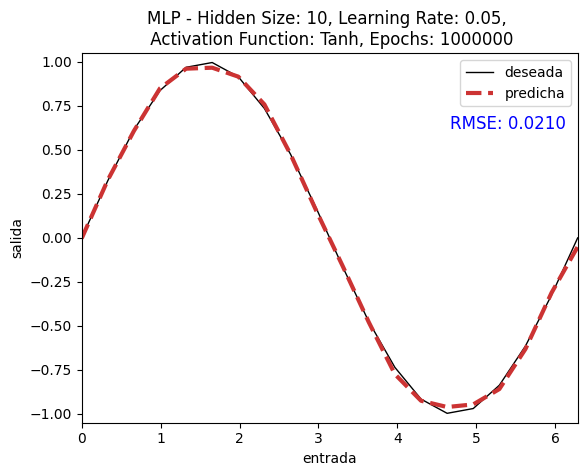

In [53]:
x = np.linspace(0.0, np.pi * 2.0, 20)
d = np.sin(x).reshape(x.size, 1) # Sin esto hay problemas a la hora de restar en el mse

y, plot_1 = predict_MLP(x, d, layer1_weights = layer1_weights, layer1_bias = layer1_bias, layer2_weights = layer2_weights, layer2_bias = layer2_bias, 
                activation_fn = activation_fn, hidden_size = hidden_size, learning_rate = learning_rate, 
                epoch = epoch, plot = True) # modificar solamente lo de plot, lo otro viene acorde a lo último entrenado

Tratamos de ver qué sucede al predecir fuera de la región de entrenamiento...

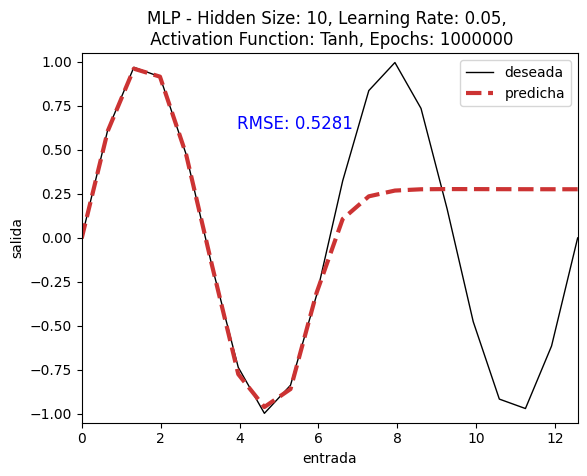

In [54]:
x = np.linspace(0.0, np.pi * 4.0, 20) # nótese el 4
d = np.sin(x).reshape(x.size, 1) # Sin esto hay problemas a la hora de restar en el mse

y, plot_5 = predict_MLP(x, d, layer1_weights = layer1_weights, layer1_bias = layer1_bias, layer2_weights = layer2_weights, layer2_bias = layer2_bias, 
                activation_fn = activation_fn, hidden_size = hidden_size, learning_rate = learning_rate, 
                epoch = epoch, plot = True, save = False) # modificar solamente lo de plot, lo otro viene acorde a lo último entrenado

Todo va bien, hasta que se sale de ella. Esto era esperable.

#### Red neuronal con una sola capa oculta con 10 neuronas, learning_rate = 0.05 y función de activación de función sigmoide.

In [55]:
layer1_weights, layer1_bias, layer2_weights, layer2_bias, layer1_sums, layer2_sums, activation_fn, hidden_size, learning_rate, activation_fn, epoch = train_MLP(sample_size = 1, hidden_size = 10, output_size = 1, learning_rate = 0.05, activation_fn = sigmoid_fn, epochs = 1e6, report_freq = 2e5)

Epoch: 0
Error: 0.000008
Epoch: 200000
Error: 0.427647
Epoch: 400000
Error: 0.356765
Epoch: 600000
Error: 0.336596
Epoch: 800000
Error: 0.336348
Epoch: 1000000
Error: 0.335857


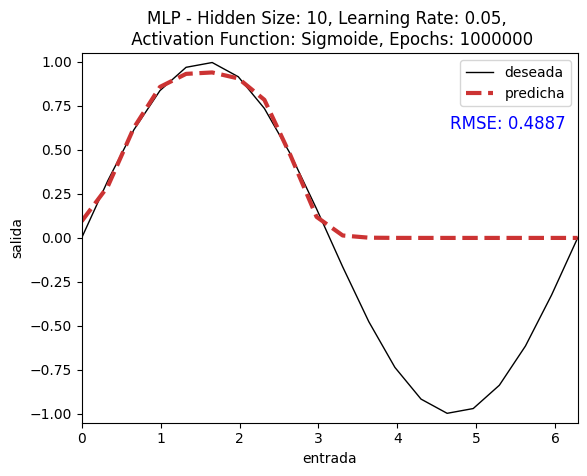

In [56]:
x = np.linspace(0.0, np.pi * 2.0, 20)
d = np.sin(x).reshape(x.size, 1) # Sin esto hay problemas a la hora de restar en el mse

y, plot_2 = predict_MLP(x, d, layer1_weights = layer1_weights, layer1_bias = layer1_bias, layer2_weights = layer2_weights, layer2_bias = layer2_bias, 
                activation_fn = activation_fn, hidden_size = hidden_size, learning_rate = learning_rate, 
                epoch = epoch, plot = True) # modificar solamente lo de plot, lo otro viene acorde a lo último entrenado

#### Red neuronal con una sola capa oculta con 15 neuronas, learning_rate = 0.1 y función de activación de función tangente hiperbólica.

In [57]:
layer1_weights, layer1_bias, layer2_weights, layer2_bias, layer1_sums, layer2_sums, activation_fn, hidden_size, learning_rate, activation_fn, epoch = train_MLP(sample_size = 1, hidden_size = 15, output_size = 1, learning_rate = 0.1, activation_fn = np.tanh, epochs = 1e6, report_freq = 2e5)

Epoch: 0
Error: 0.000000


Epoch: 200000
Error: 0.294186
Epoch: 400000
Error: 0.023982
Epoch: 600000
Error: 0.021449
Epoch: 800000
Error: 0.019968
Epoch: 1000000
Error: 0.018637


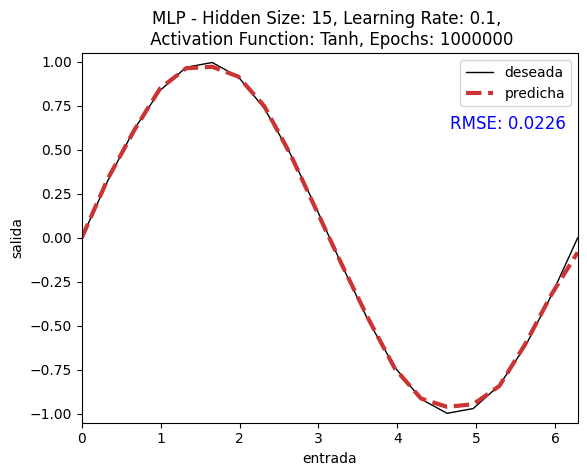

In [58]:
x = np.linspace(0.0, np.pi * 2.0, 20)
d = np.sin(x).reshape(x.size, 1) # Sin esto hay problemas a la hora de restar en el mse

y, plot_3 = predict_MLP(x, d, layer1_weights = layer1_weights, layer1_bias = layer1_bias, layer2_weights = layer2_weights, layer2_bias = layer2_bias, 
                activation_fn = activation_fn, hidden_size = hidden_size, learning_rate = learning_rate, 
                epoch = epoch, plot = True) # modificar solamente lo de plot, lo otro viene acorde a lo último entrenado

#### Red neuronal con una sola capa oculta con 15 neuronas, learning_rate = 0.1 y función de activación sigmoide.

In [59]:
layer1_weights, layer1_bias, layer2_weights, layer2_bias, layer1_sums, layer2_sums, activation_fn, hidden_size, learning_rate, activation_fn, epoch = train_MLP(sample_size = 1, hidden_size = 15, output_size = 1, learning_rate = 0.1, activation_fn = sigmoid_fn, epochs = 1e6, report_freq = 2e5)

Epoch: 0
Error: 0.000008
Epoch: 200000
Error: 0.353799
Epoch: 400000
Error: 0.337249
Epoch: 600000
Error: 0.334676
Epoch: 800000
Error: 0.333373
Epoch: 1000000
Error: 0.330766


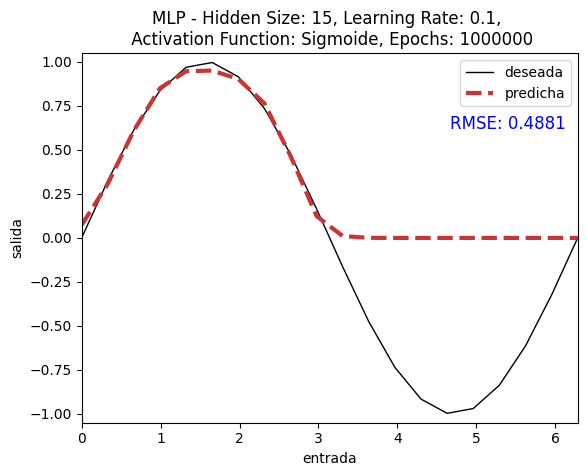

In [60]:
x = np.linspace(0.0, np.pi * 2.0, 20)
d = np.sin(x).reshape(x.size, 1) # Sin esto hay problemas a la hora de restar en el mse

y, plot_4 = predict_MLP(x, d, layer1_weights = layer1_weights, layer1_bias = layer1_bias, layer2_weights = layer2_weights, layer2_bias = layer2_bias, 
                activation_fn = activation_fn, hidden_size = hidden_size, learning_rate = learning_rate, 
                epoch = epoch, plot = True) # modificar solamente lo de plot, lo otro viene acorde a lo último entrenado

Mostrando todas las gráficas juntas para una comparación.

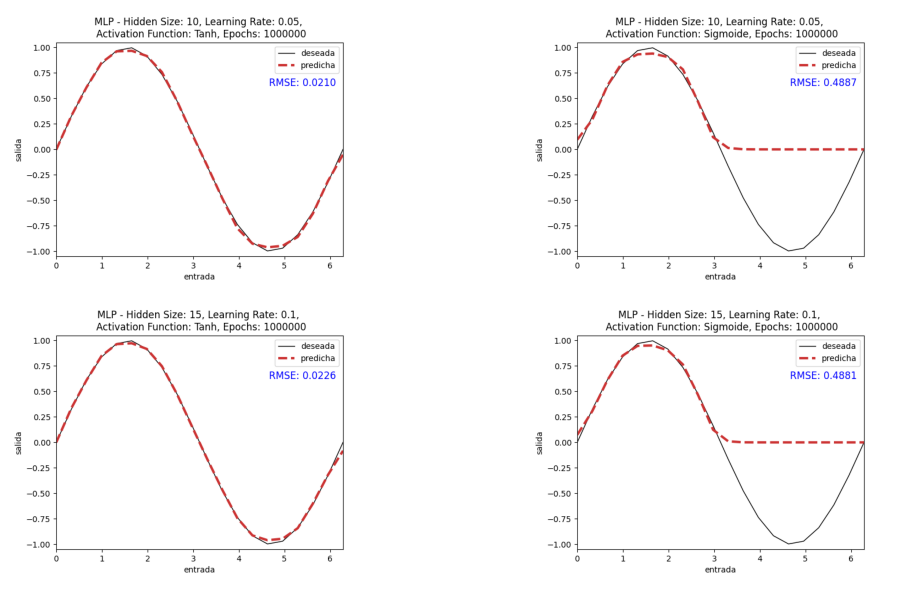

In [61]:
import os
import matplotlib.pyplot as plt
from PIL import Image

directory = 'images/'  

# Imágenes presentes en el directorio:

image_files = [file for file in os.listdir(directory) if file.endswith('.png')]

# Crear un subplot con el número adecuado de filas y columnas
num_images = len(image_files)
num_cols = 2  # Puedes ajustar el número de columnas según tu preferencia
num_rows = (num_images + num_cols - 1) // num_cols

# Configurar el tamaño del plot
fig, axes = plt.subplots(num_rows, num_cols, figsize = (12, 6))

# Iterar sobre los archivos de imagen y mostrar cada imagen en un subplot
for i, image_file in enumerate(image_files):
    img = Image.open(os.path.join(directory, image_file))
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]
    ax.imshow(img)
    ax.axis('off')  # Ocultar los ejes

# Ajustar el espaciado entre subplots y mostrar el plot
plt.tight_layout()
plt.show()


Observamos cómo los resultados obtenidos son drásticamente mejores para una función de activación de tangente hiperbólica (Tanh), respecto a la Sigmoide. En esta última vemos que había un problema enorme en el punto de inflexión del seno (situado en Pi). 

Las mayores desviaciones en el caso de uso de la tangente hiperbólica están en los cambios más bruscos en la segunda derivada.

Vemos además cómo con un learning-rate y número de neuronas en capa oculta menor hemos podido capturar una mejor relación.

Por otra parte, ya vimos que obteníamos malos resultados cuando tratábamos de predecir valores fuera del rango de entrenamiento. Esto nos permite darnos cuenta de la enorme importancia que tiene un muestreo adecuado a la hora de entrenar un modelo.

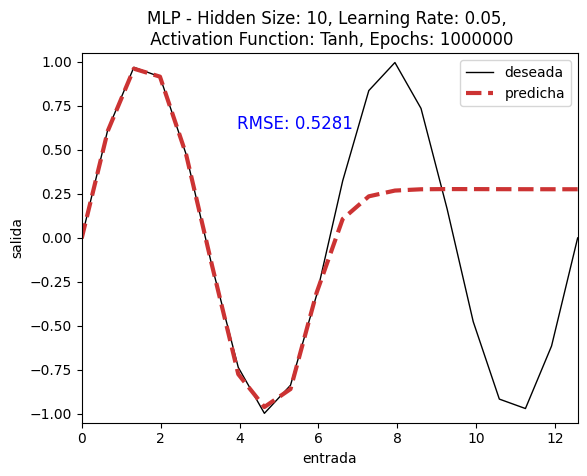

In [63]:
plot_5